<a href="https://colab.research.google.com/github/Anisafi/uas_datmin/blob/main/DecisionTreeDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. Hubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 2. Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score # Changed import here

In [6]:
# 3. Sesuaikan path ke lokasi file di Google Drive kamu
file_path = '/content/drive/MyDrive/DM/winequality-red.csv'
df = pd.read_csv(file_path, sep=';')
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
# 4. Cek Tipe Data dan Missing Values
print(df.dtypes)
print("\nMissing values:")
print(df.isna().sum())


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


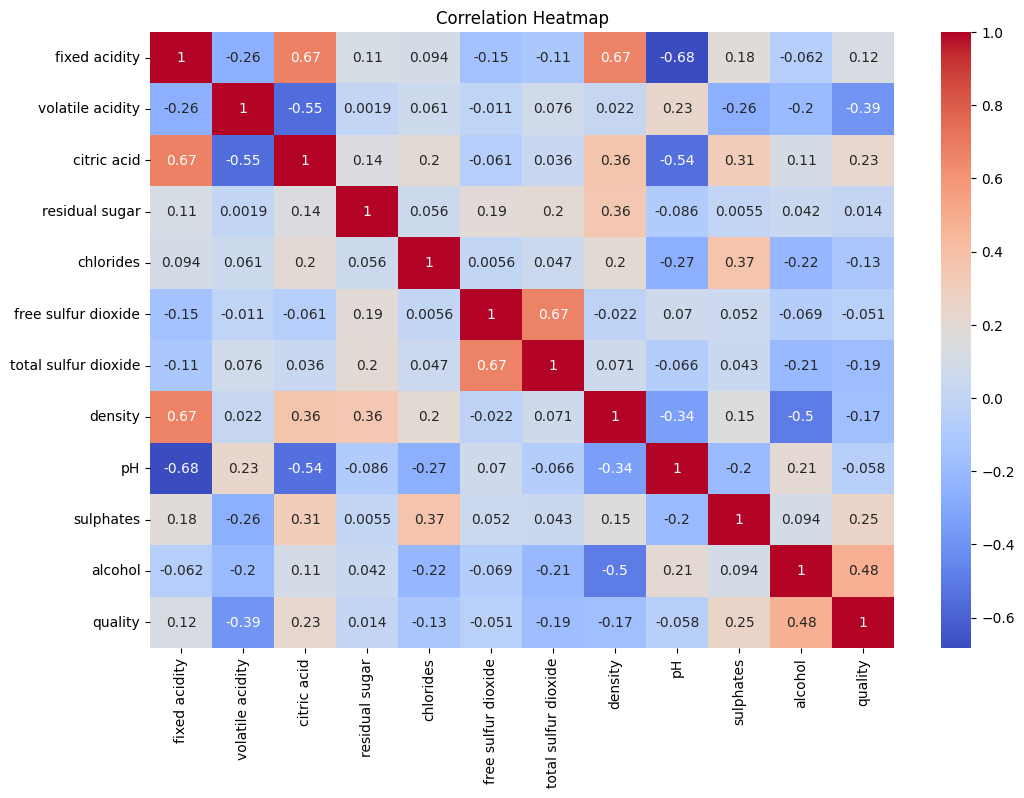

In [9]:
# 5. Korelasi & Visualisasi Awal
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


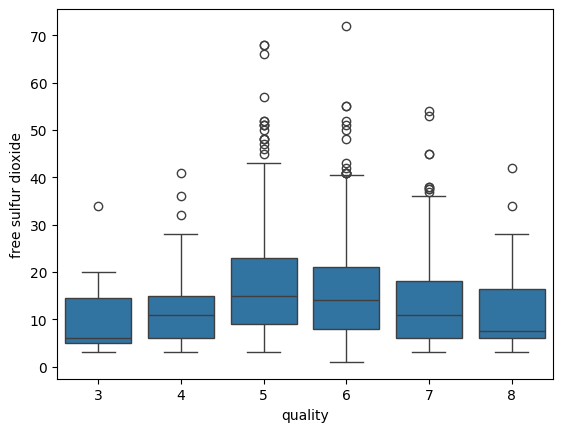

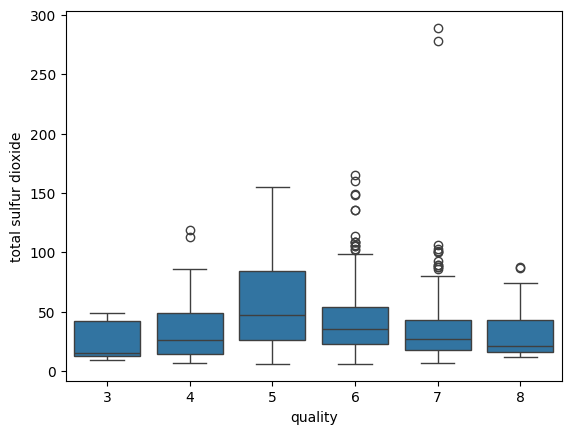

In [10]:
# 6. Boxplot dan Drop Kolom

sns.boxplot(x='quality', y='free sulfur dioxide', data=df)
plt.show()

sns.boxplot(x='quality', y='total sulfur dioxide', data=df)
plt.show()

# Drop kolom yang kurang relevan
df = df.drop(['fixed acidity', 'free sulfur dioxide'], axis=1)

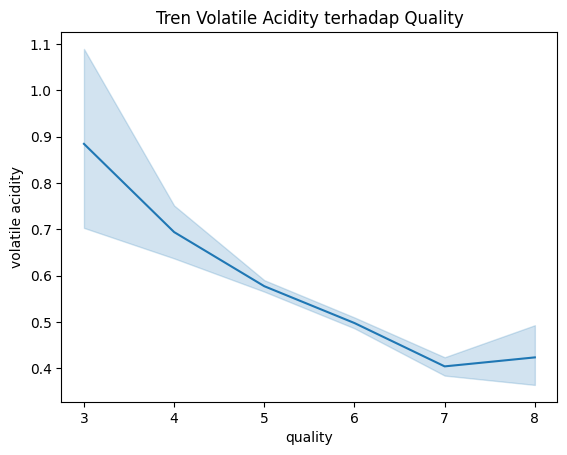

In [11]:
# 7. Visualisasi Fitur
sns.lineplot(x='quality', y='volatile acidity', data=df)
plt.title("Tren Volatile Acidity terhadap Quality")
plt.show()


quality
0    1382
1     217
Name: count, dtype: int64


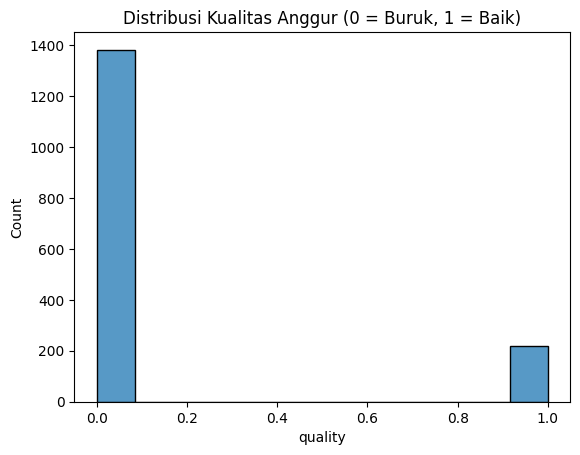

In [12]:
# 8. Definisikan Fitur dan Label
X = df.iloc[:, 1:9]
Y = df.iloc[:, 9]

# Konversi kualitas menjadi binary: 0 (Buruk), 1 (Bagus)
Y = Y.apply(lambda x: 0 if x <= 6.5 else 1)

# Cek distribusi kelas
print(Y.value_counts())
sns.histplot(data=Y)
plt.title("Distribusi Kualitas Anggur (0 = Buruk, 1 = Baik)")
plt.show()

In [16]:
# 9. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


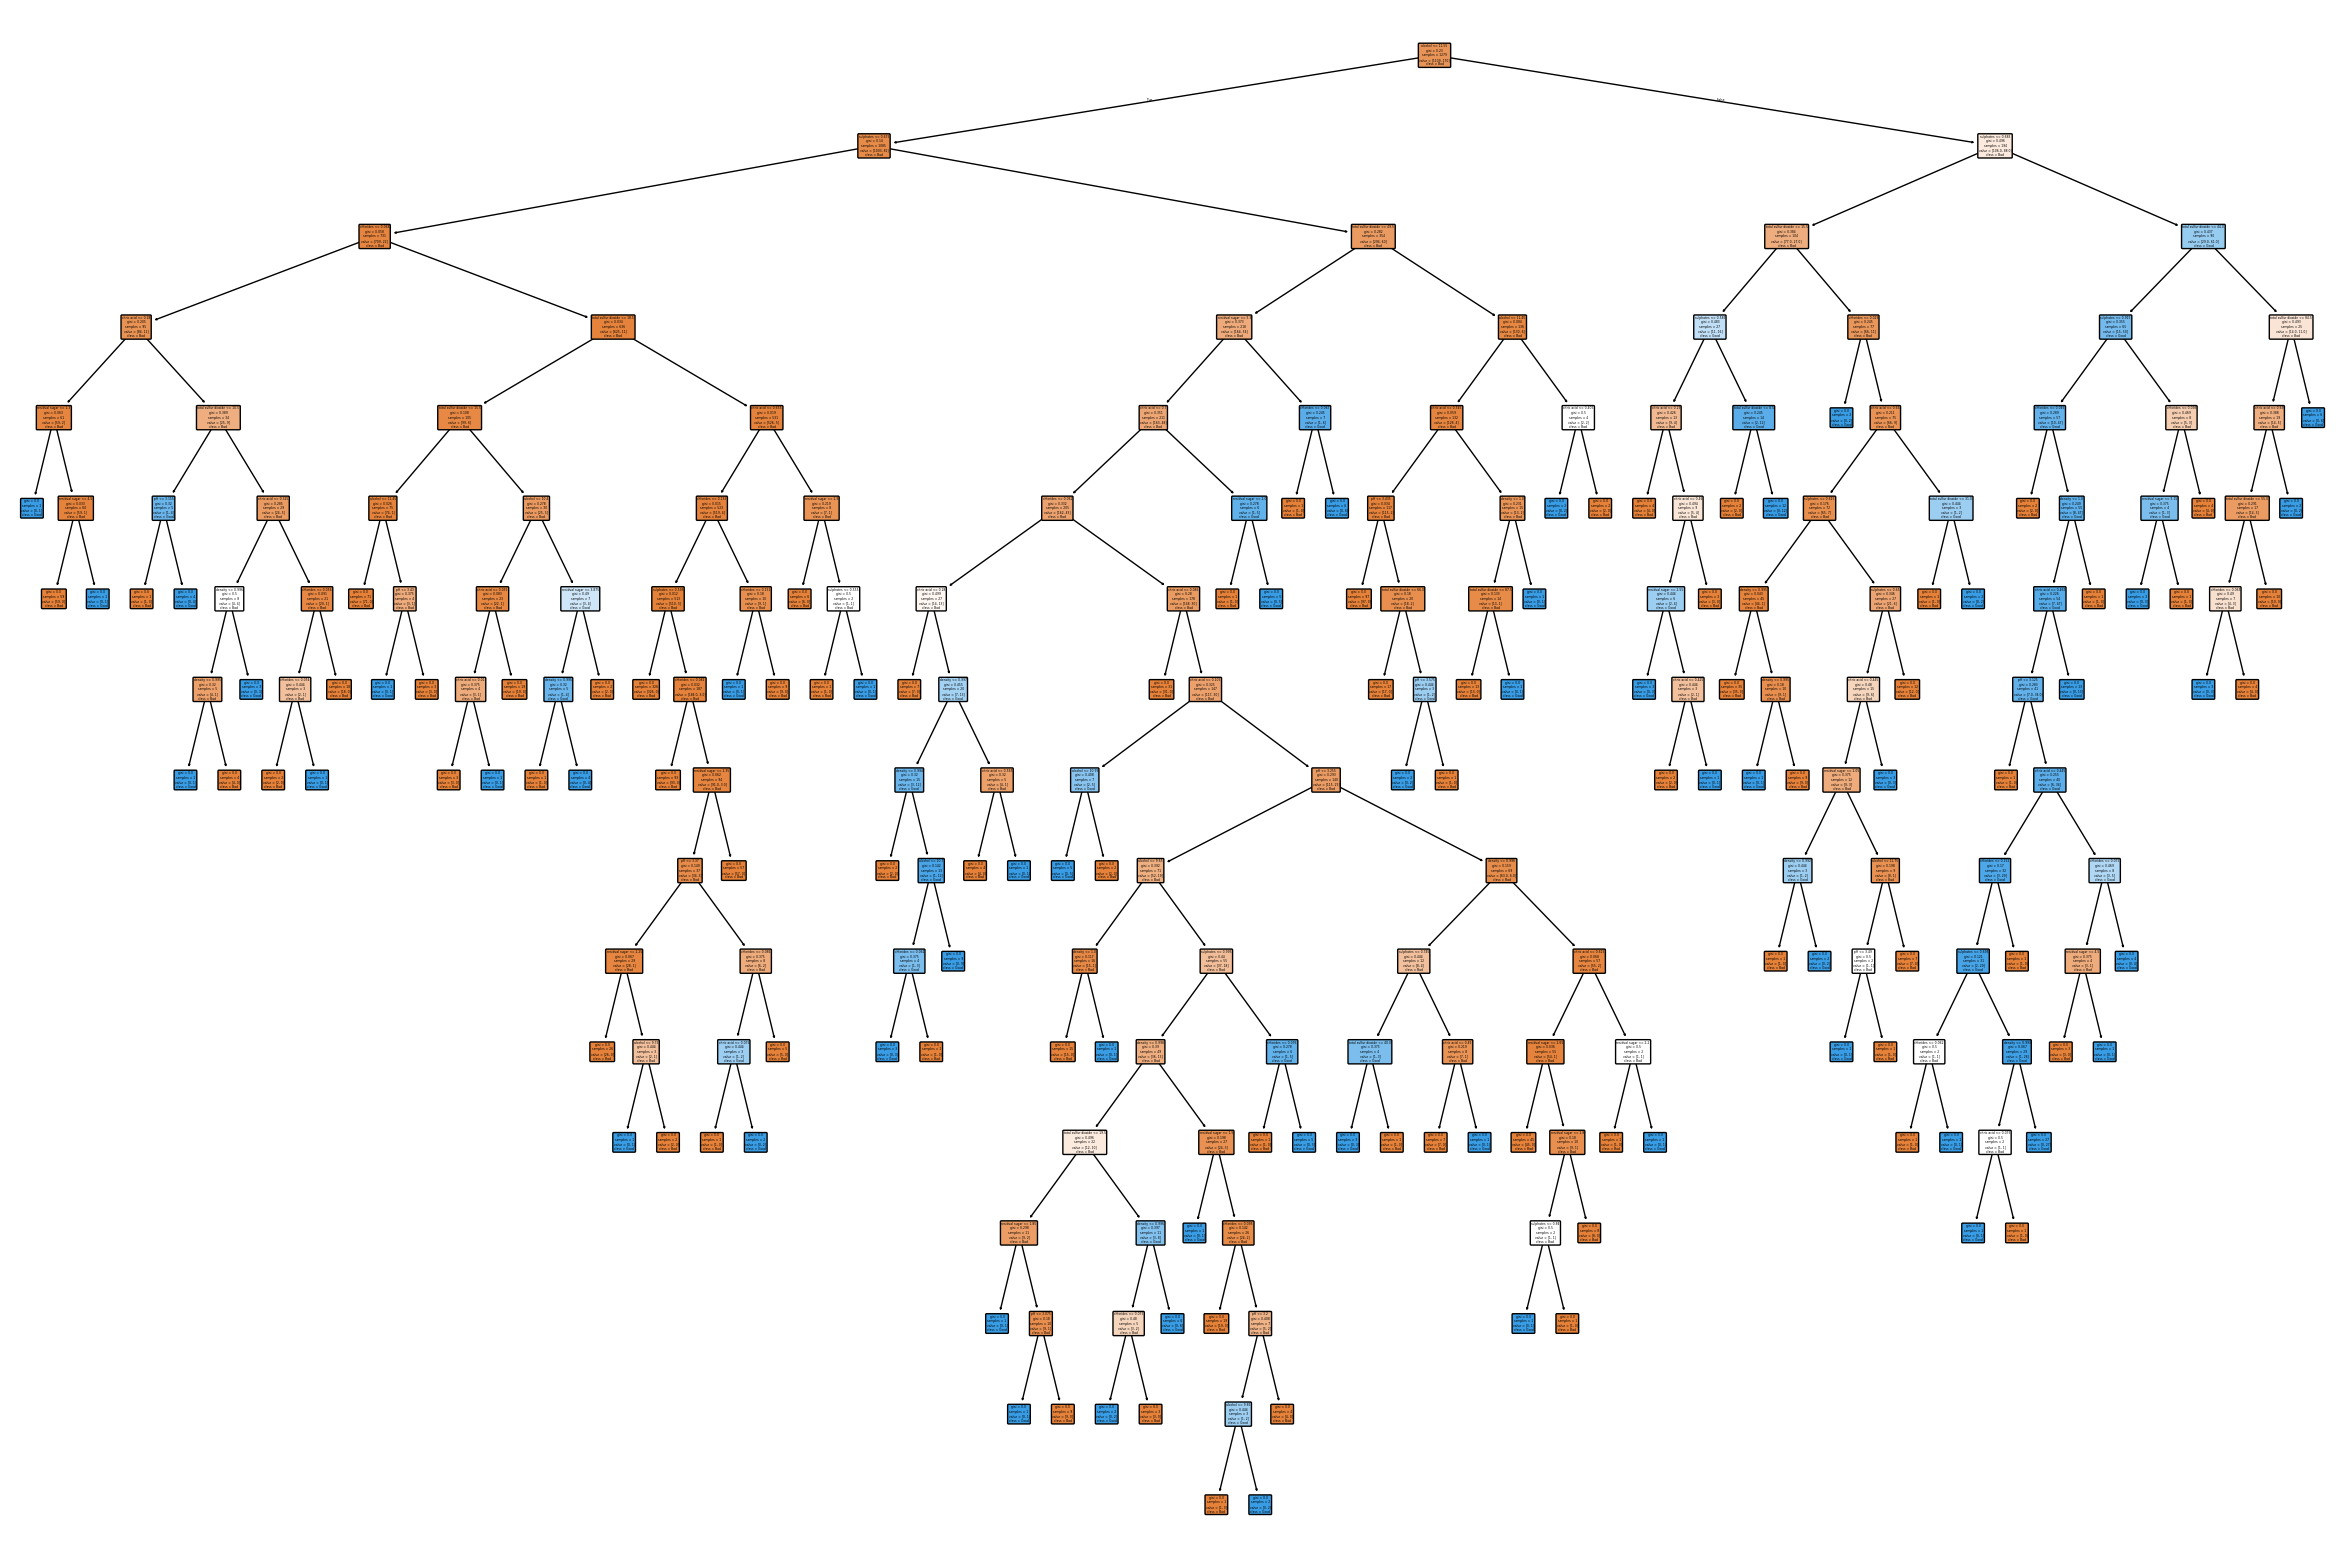

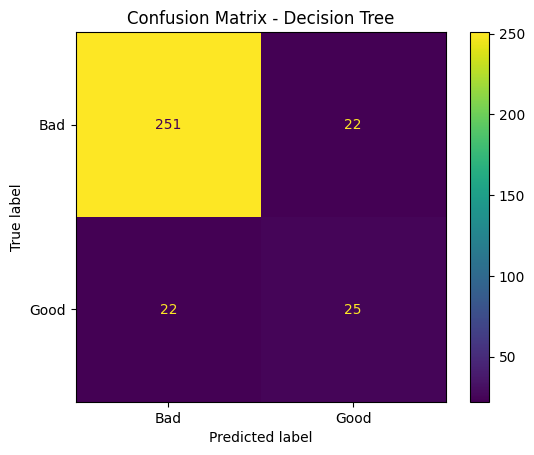

Akurasi Decision Tree (sebelum pruning): 86.25 %


In [17]:
# 10. Latih Model Decision Tree
DC = DecisionTreeClassifier(random_state=42)
model = DC.fit(X_train, y_train)

plt.figure(figsize=(30, 20))
plot_tree(model, filled=True, rounded=True, feature_names=X.columns, class_names=["Bad", "Good"])
plt.show()

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Bad", "Good"])
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Akurasi model awal
y_pred = model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred)
print("Akurasi Decision Tree (sebelum pruning):", round(accuracy_dt * 100, 2), "%")

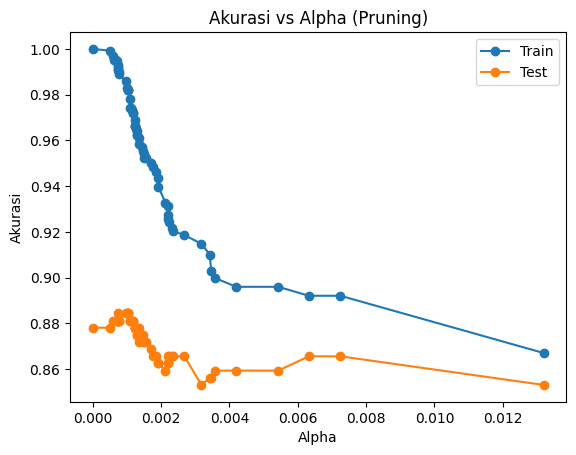

In [18]:
# 11. Cost Complexity Pruning
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]
clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

train_scores = [clf.score(X_train, y_train) for clf in clf_dts]
test_scores = [clf.score(X_test, y_test) for clf in clf_dts]

plt.figure()
plt.plot(ccp_alphas, train_scores, marker='o', label='Train')
plt.plot(ccp_alphas, test_scores, marker='o', label='Test')
plt.xlabel('Alpha')
plt.ylabel('Akurasi')
plt.legend()
plt.title("Akurasi vs Alpha (Pruning)")
plt.show()



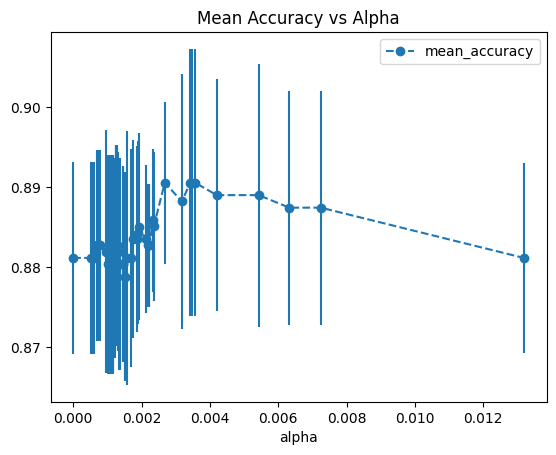

Best alpha: 0.0034257087423623794


In [19]:
# 12. Cross Validation untuk Cari Alpha Terbaik
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')
plt.title("Mean Accuracy vs Alpha")
plt.show()

best_alpha = alpha_results.iloc[alpha_results['mean_accuracy'].idxmax()]['alpha']
print("Best alpha:", best_alpha)



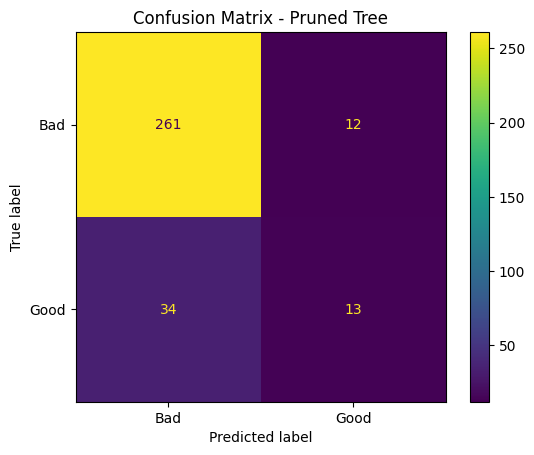

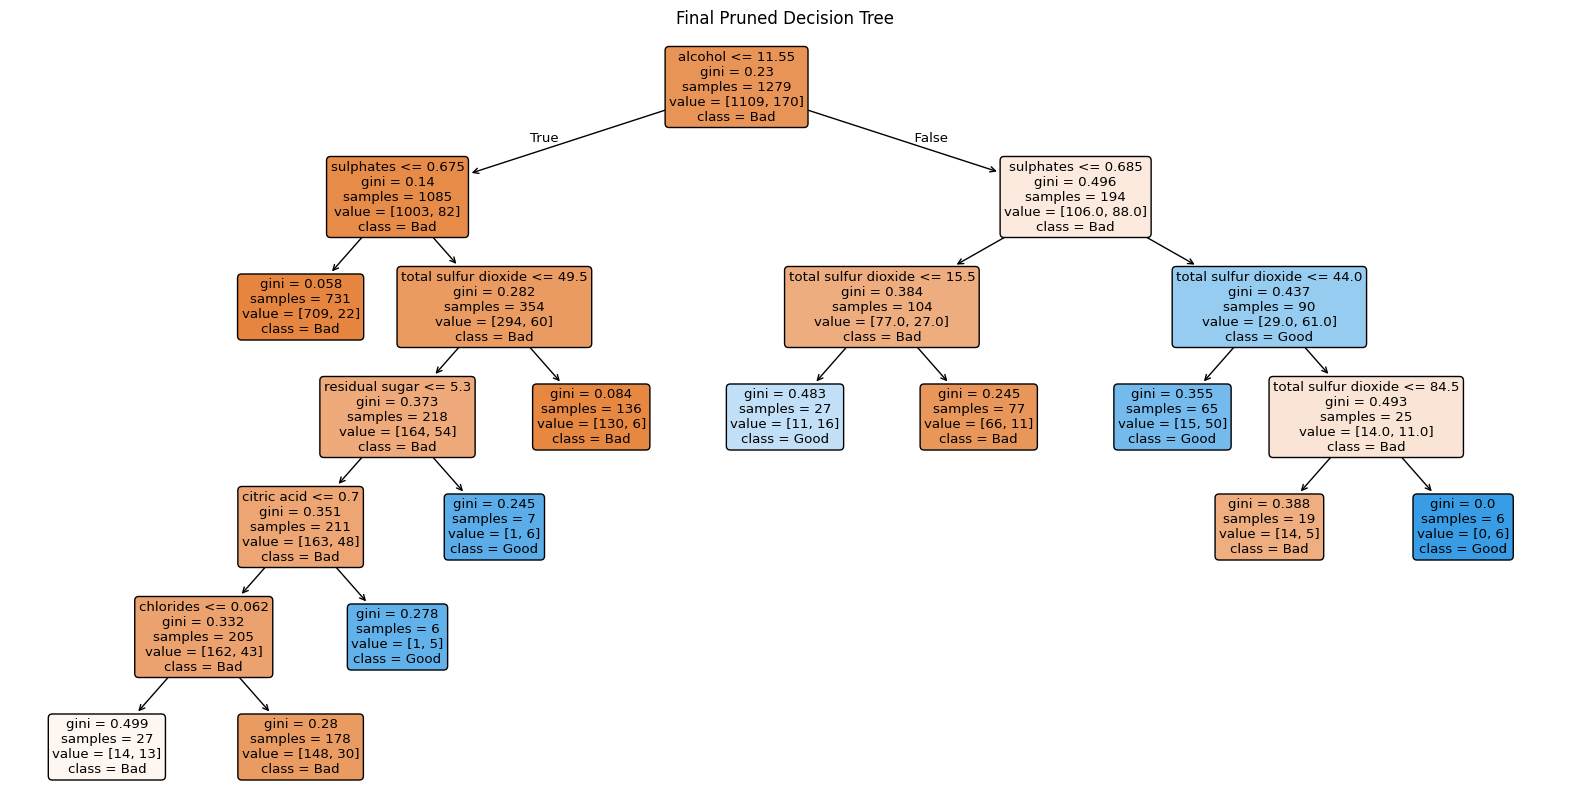

Akurasi Decision Tree (setelah pruning): 85.62 %


In [20]:
# 13. Evaluasi Final Model (Pruned Tree)
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_dt_pruned.fit(X_train, y_train)

ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test, y_test, display_labels=["Bad", "Good"])
plt.title("Confusion Matrix - Pruned Tree")
plt.show()

plt.figure(figsize=(20,10))
plot_tree(clf_dt_pruned, filled=True, rounded=True, feature_names=X.columns, class_names=["Bad", "Good"])
plt.title("Final Pruned Decision Tree")
plt.show()

# Akurasi model setelah pruning
y_pred_pruned = clf_dt_pruned.predict(X_test)
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
print("Akurasi Decision Tree (setelah pruning):", round(accuracy_pruned * 100, 2), "%")